In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 集成学习(Ensemble Learning)

传统机器学习算法 (例如：决策树，人工神经网络，支持向量机等) 的目标都是寻找一个最优分类器尽可能的将训练数据分开。
集成学习 (Ensemble Learning) 算法的基本思想就是将多个分类器组合，从而实现一个预测效果更好的集成分类器。

集成算法可以说从一方面验证了中国的一句老话：三个臭皮匠，赛过诸葛亮。




* 同构集成学习与异构集成学习

<center>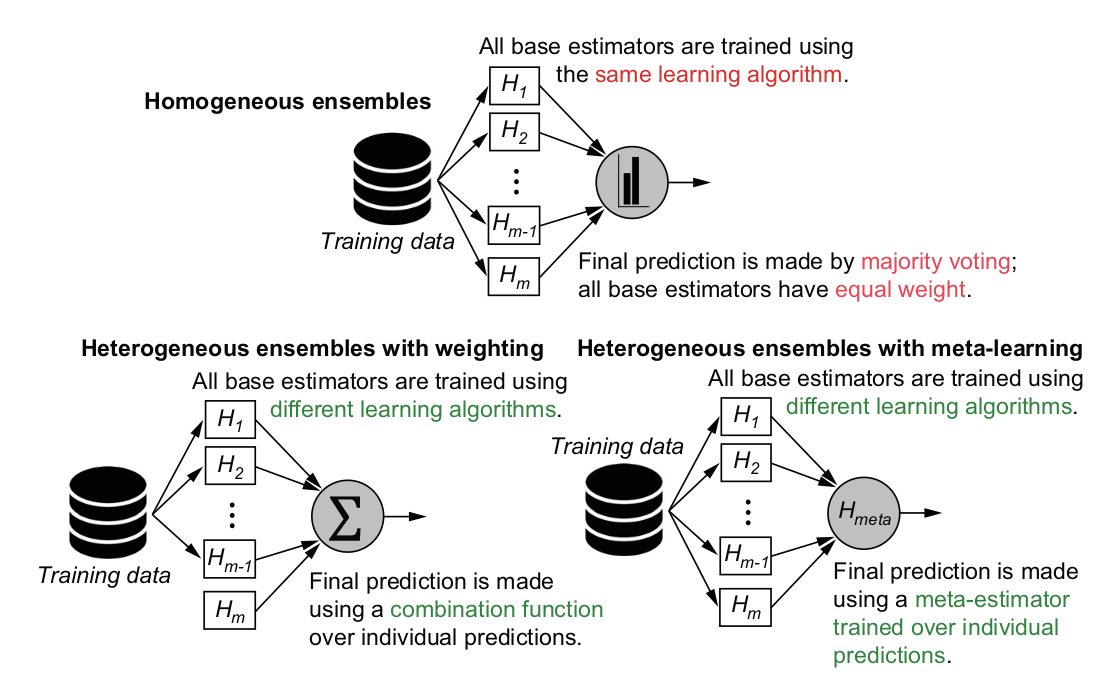</center>


又可细分为三大类：
1. **bagging**
2. **boosting**
3. **stacking**



## Bagging

Bagging是**B**ootstrap **agg**regat**ing**的简写。其中，**Bootstrap**可翻译为**自助法**。

### 自助法

自助法（Bootstrap）是一种有放回的抽样方法。
Bootstrap原意是“鞋提”，自助这个意思来自于英文习语“pull oneself up by one's bootstraps”，其字面意思是“字面意思是“通过拉自己的鞋提来把自己提起来”。
虽然从物理上讲，这显然是一件不可能完成的事情，但引申的意思是：在没有外界帮助的情况下，依靠自身有限的资源和努力来改善自己的处境，实现一个看似不可能的目标，即实现“自力更生”、“自我驱动”、“内部挖潜”的比喻。

> 在早期，可以利用bootstrap方法计算某个统计量的分布以及置信区间：
> 1. 采用有放回抽样的方法，从原始样本中抽取一定数量$m$的样本;
> 1. 根据抽出的样本计算想要得到的统计量$T$;
> 1. 重复上述$N$次（一般大于1000），得到$N$个统计量$T$;
> 1. 根据这$N$个统计量，即可计算出统计量的置信区间。

#### 数值实验

设计一个实验：以正态分布随机产生$n=100$个样本。
* 第一组试验：使用参数估计的方法，估计该样本的\mu的95%置信区间。
* 第二组试验：使用自助法估计该样本的其95%置信区间。

反复重复这两组试验$m=500$次。

### Random Forest（随机森林）

Bagging的主要思路就是采样出$T$个含有$m$个训练样本的采样集，然后基于每个采样集训练出一个"弱"分类器，再将这些分类器进行综合（平均/投票）。



随机森林（Random Forest）就属于Bagging。随机森林简单地来说就是用随机的方式建立一个森林，森林由很多的决策树组成，随机森林的每一棵决策树之间是没有关联的。


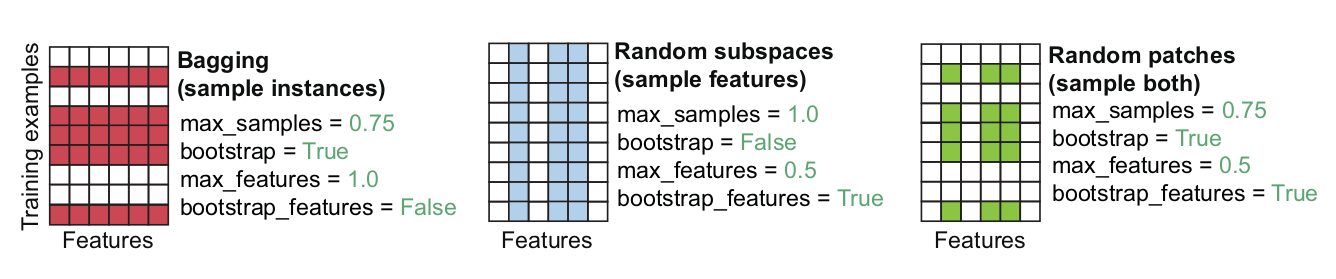


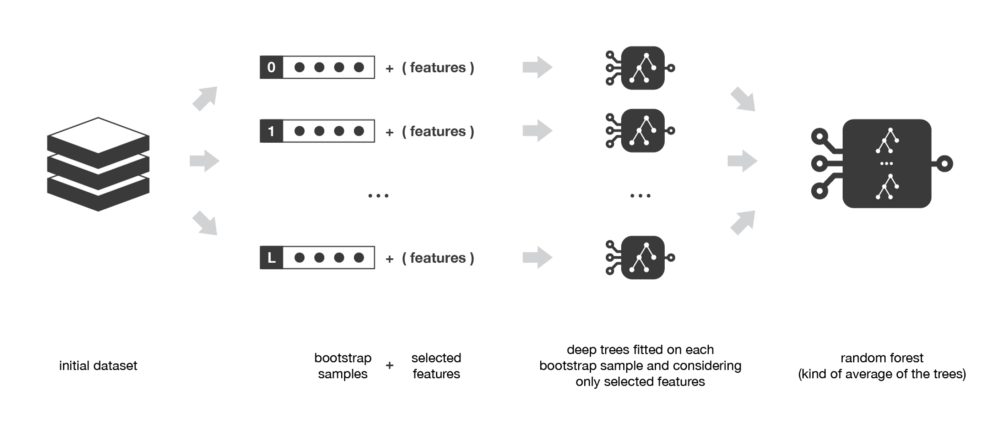

在随机森林中，有$T$棵决策树，每颗决策树（弱学习器）都有两个随机抽样的过程：对输入数据的行（数据的数量）与列（数据的特征）都进行抽样:
1. 对于行采样，采用有放回的方式，若有$N$个数据，则采样出$m$个数据（可能有重复），这样在训练的时候每一棵树都不是全部的样本；
1. 接着进行列采样从$K$个特征中选择出$k$个，一般选择$k=\log_2\left(K\right) \ll K$）。
如果$k=K$，此时随机森林的决策树和普通的决策树没有区别。$k$，则模型约健壮，当然此时对于训练集的拟合程度会变差。也就是说$k$越小，模型的方差会减小，但是偏差会增大。在实际案例中，一般会通过交叉验证调参获取一个合适的$k$的值。

最后，综合$T$棵决策树的结果：如果是分类问题，则$T$个弱学习器(决策树)投出最多票数的类别或者类别之一为最终类别。如果是回归算法，$T$个弱学习器得到的回归结果进行算术平均得到的值为最终的模型输出。


### 随机森林小实验

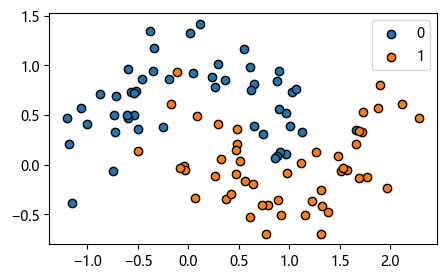

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

plt.figure(figsize=(5,3), dpi=100)
plt.scatter(X[y==0, 0], X[y==0, 1], ec="k", label="0")
plt.scatter(X[y==1, 0], X[y==1, 1], ec="k", label="1")
plt.legend();

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50,
                                max_samples=0.5, max_features=1, 
                                max_depth=5,
                                random_state=42)
forest.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


与随机森林相关的模型参数
* n_estimators 森林中树的个数
* max_samples 抽样最大的样本数或抽样量占总量的比例
* max_features 树最大的特征抽样个数
> 在`scikit-learn`实现中，如果没有达到有效的划分，则会一直继续尝试使用新的特征，即使已经超过`max_features`
> 


在本例子中，数据维度和参数设置对随机森林稍有不公。森林只有$8$棵树，数据也只有$2$个特征，无法发挥自助法的优势。


In [26]:
def plot_tree_partition(tree, X, y, eps=1, mesh_num=50, alpha=0.5, cmap='viridis', ax=None):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, mesh_num),
                         np.linspace(y_min, y_max, mesh_num))

    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=alpha, cmap=cmap, levels=2)
    

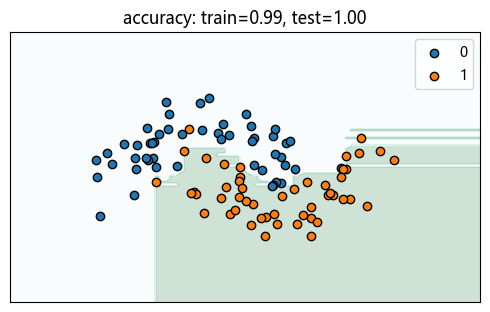

In [33]:
from sklearn.metrics import accuracy_score
plt.figure(figsize=(5,3), dpi=100)
plot_tree_partition(forest, X, y, alpha=0.2, cmap=plt.cm.BuGn, mesh_num=100)
plt.scatter(X[y==0, 0], X[y==0, 1], ec="k", label="0")
plt.scatter(X[y==1, 0], X[y==1, 1], ec="k", label="1")
plt.xticks([]); plt.yticks([]);
plt.legend();
plt.tight_layout();

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)
plt.title(f"accuracy: train={accuracy_score(y_train, pred_train):0.2f}" 
          f", test={accuracy_score(y_test, pred_test):0.2f}");

森林中树的情况

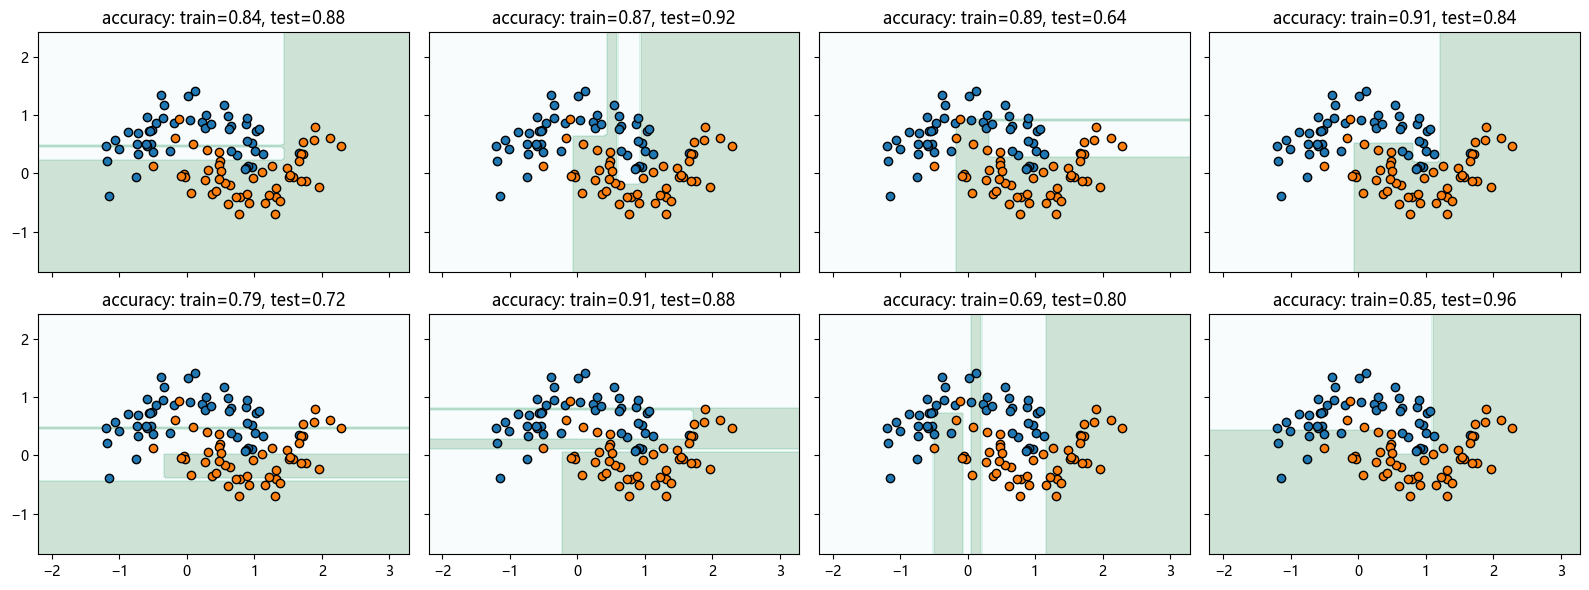

In [34]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators=8, max_samples=0.5, max_features=1, random_state=100)
# forest.fit(X_train, y_train)


fig, axes = plt.subplots(2, 4, figsize=(16,6), dpi=100, sharex=True, sharey=True)
axes = axes.ravel()
for i in range(8):
    tree = forest.estimators_[i]
    ax = axes[i]
    plot_tree_partition(tree, X, y, alpha=0.2, cmap=plt.cm.BuGn, ax=ax, mesh_num=100)
    ax.scatter(X[y==0, 0], X[y==0, 1], ec="k", label="0")
    ax.scatter(X[y==1, 0], X[y==1, 1], ec="k", label="1")
    
    pred_train = tree.predict(X_train)
    pred_test  = tree.predict(X_test)    
    ax.set_title(f"accuracy: train={accuracy_score(y_train, pred_train):0.2f}" 
          f", test={accuracy_score(y_test, pred_test):0.2f}");
plt.tight_layout()

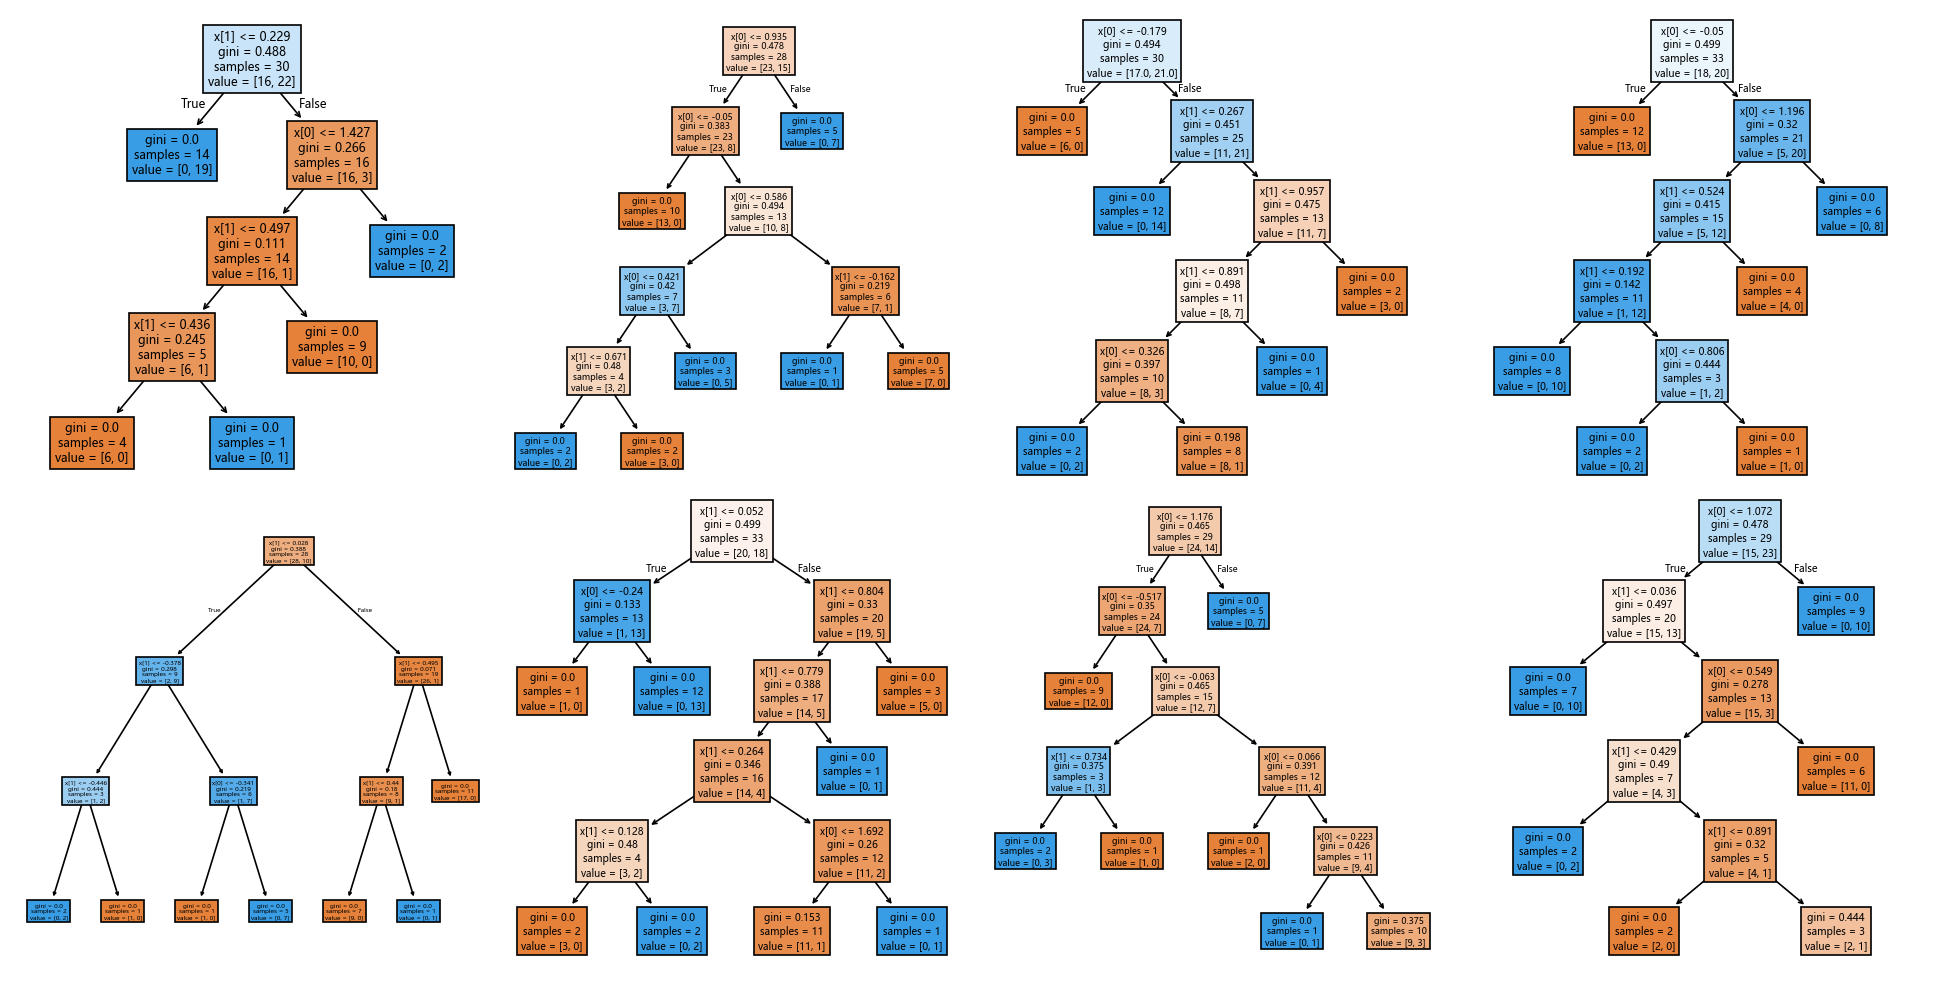

In [35]:
from sklearn.tree import plot_tree
fig, axes = plt.subplots(2, 4, figsize=(16, 8), dpi=120, sharex=True, sharey=True)
axes = axes.ravel()
for i in range(8):
    tree = forest.estimators_[i]
    plot_tree(tree, filled=True, ax=axes[i]);
    axes[i].axis("off")
plt.tight_layout(pad=0)

随机森林的主要优点有：
1. 训练可以高度并行化。
1. 由于可以随机选择决策树节点划分特征，这样在样本特征维度很高的时候，仍然能高效的训练模型。
1. 由于采用了随机采样，训练出的模型的方差小，泛化能力强。
1. 对部分特征缺失不敏感。
1. 机森林可以处理高维数据，无需进行特征选择，在训练过程中可以得出不同特征对模型的重要性程度。

随机森林的主要缺点有：
1. 在噪音比较大的样本集上，容易陷入过拟合。
1. 取值划分比较多的特征容易对随机森林的决策产生更大的影响，从而影响拟合的模型的效果。

### 随机森林案例：癌症肿瘤识别

In [38]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, 
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=42)
forest.fit(X_train, y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

print(f"Accuracy on training set: { accuracy_score(y_train, pred_train) :.3f}")
print(f"Accuracy on test set: { accuracy_score(y_test, pred_test) :.3f}")

Accuracy on training set: 0.930
Accuracy on test set: 0.916


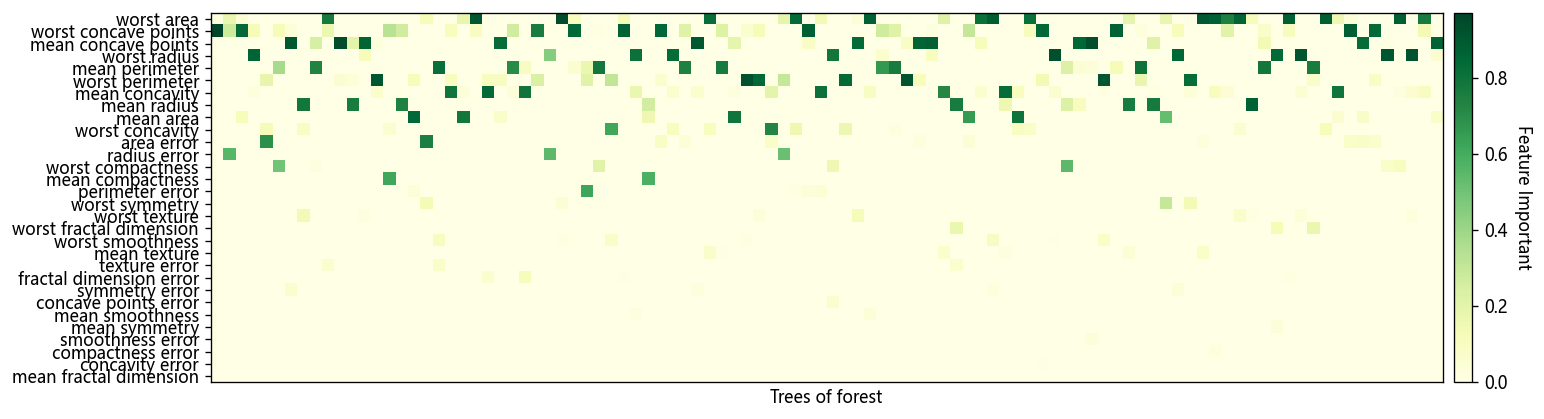

In [21]:
tree_importances = np.vstack([tree.feature_importances_ for tree in forest.estimators_])

importances = tree_importances.mean(axis=0)
importances_std = tree_importances.std(axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(24,4), dpi=120)
ax = plt.gca()
im = ax.imshow(tree_importances.T[indices,:], cmap="YlGn")
cbar = ax.figure.colorbar(im, ax=ax, pad=0.005)
cbar.ax.set_ylabel("Feature Important", rotation=-90, va="bottom")

ax.set_xticks([])
ax.set_yticks(np.arange(len(cancer.feature_names)))
ax.set_yticklabels(cancer.feature_names[indices]);
ax.set_xlabel("Trees of forest");

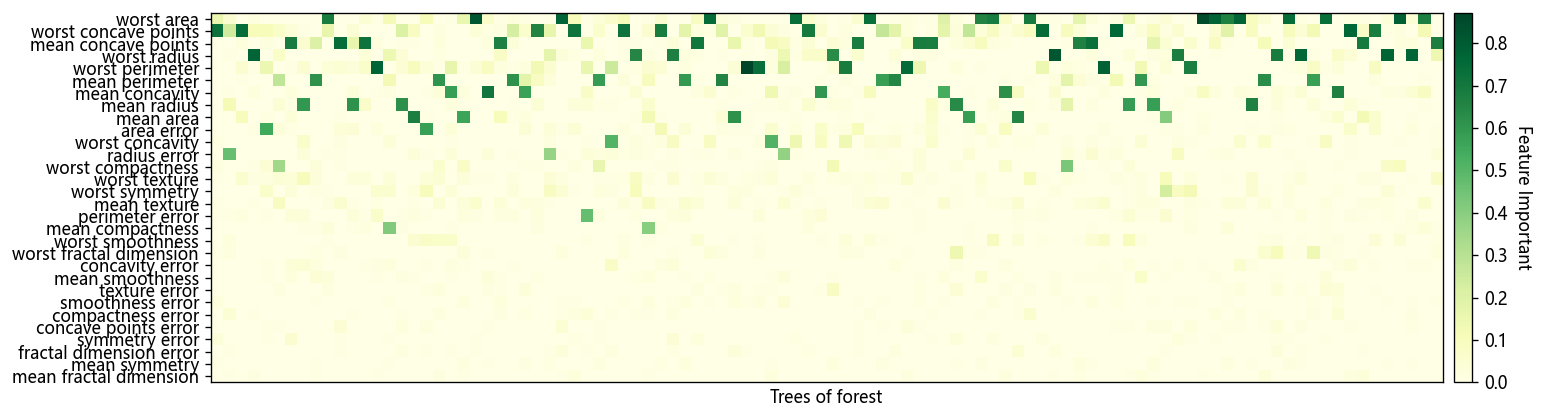

In [19]:
tree_importances = np.vstack([tree.feature_importances_ for tree in forest.estimators_])

importances = tree_importances.mean(axis=0)
importances_std = tree_importances.std(axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(24,4), dpi=120)
ax = plt.gca()
im = ax.imshow(tree_importances.T[indices,:], cmap="YlGn")
cbar = ax.figure.colorbar(im, ax=ax, pad=0.005)
cbar.ax.set_ylabel("Feature Important", rotation=-90, va="bottom")

ax.set_xticks([])
ax.set_yticks(np.arange(len(cancer.feature_names)))
ax.set_yticklabels(cancer.feature_names[indices]);
ax.set_xlabel("Trees of forest");

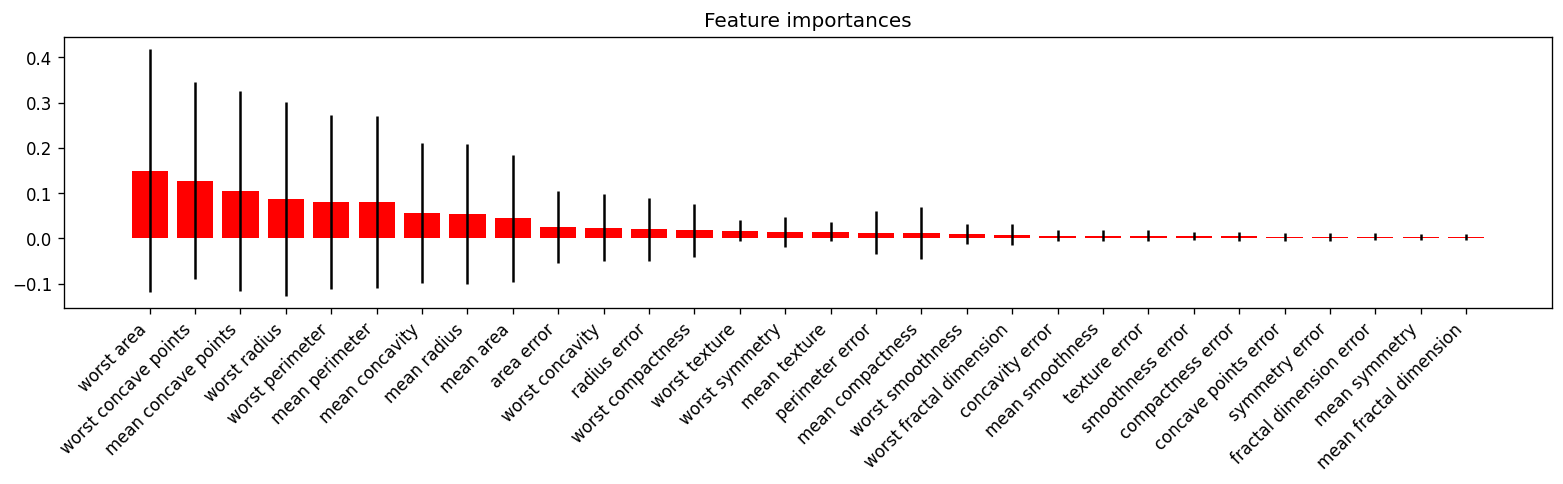

In [9]:
plt.figure(figsize=(16, 3), dpi=120)
ax = plt.gca()
ax.set_title("Feature importances")
ax.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=importances_std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]));
ax.set_xticklabels(cancer.feature_names[indices], rotation=45, horizontalalignment='right', fontsize=10);

## Boosting （提升法）

Boosting方法是基于错误提升分类器性能，通过集中关注被已有分类器分类错误的样本，构建新分类器并集成。模型每次迭代时通过调整错误样本的损失权重,提升对数据样本整体的处理精度。Boosting与Bagging 相比来说最大的区别就是Boosting是串行的，而Bagging中所有的分类器是可以同时生成的，之间没有什么关系，而Boosting中则必须先生成第一个分类器，然后根据第一个分类器的结果生成第二个分类器，依次往后进行。

### AdaBoost (Adaptive Boosting)
Boosting主要思路，Adaboost在每次迭代中都要更新样本的权重。学习好的相对降低权重，学习差的相对提高权重。:
1. 从训练集用初始权重，例如, $w_i=\frac{1}{N}$。训练出一个弱学习器$1$.
2. 根据该学习器$1$的学习误差率更新训练样本的权重。使得这次训练误差率高的训练样本点的权重变高。
3. 然后基于调整权重后的训练集训练弱，得到弱学习器$2$。
4. 如此重复进行，直到弱学习器数达到事先指定的数目$T$。
5. 最终将这$T$个弱学习器通过综合策略进行整合，得到最终的强学习器。对于分类问题，采用有权重的投票方式；对于回归问题，采用加权平均得到预测值。

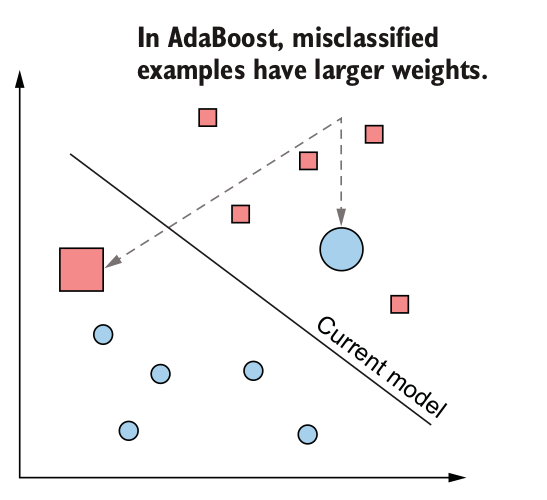


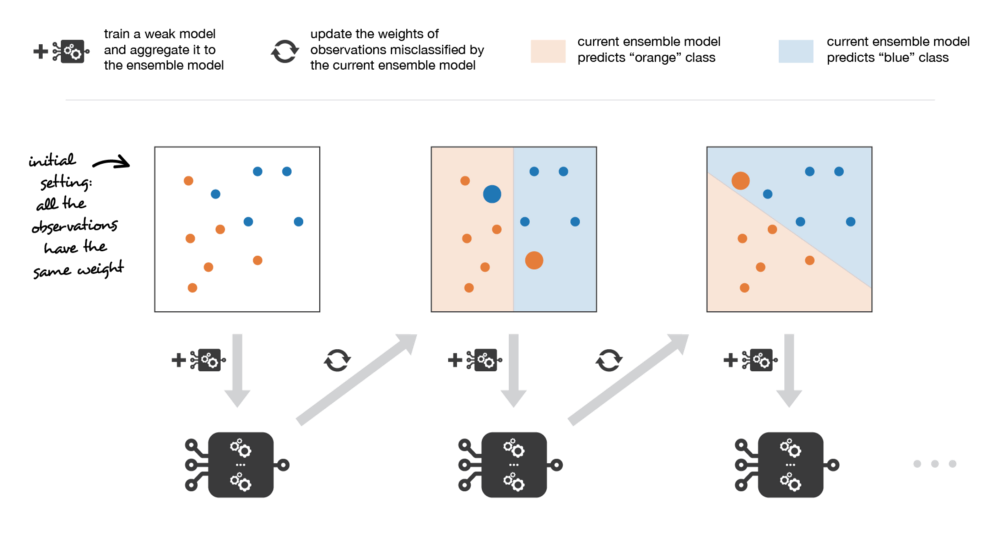

### 梯度提升决策树(Gradient Boosting Decision Trees, GBDT)

GBDT 作为一种 Ensemble Learning 算法，本质也就是融合多个弱分类器进行决策。从 GBDT 的名字可以看出，它包含两个概念：DT(Decision Tree)意思是决策树，GB是Gradient Boosting，是一种学习策略。GBDT的含义就是用Gradient Boosting的策略训练出来的DT模型。

梯度提升(Gradient boosting)学习策略的核心思路是在每次迭代中更新**样本的值**（相比较AdaBoost更新对象是样本的**权重**），每次迭代训练一个弱学习器以拟合“伪残差”(*pseudo-residuals*)。每次迭代计算的目的是为了减少上一次的残差(residual)，因此为了消除残差，我们在残差减少的梯度 (Gradient)方向上建立一个新的学习器。

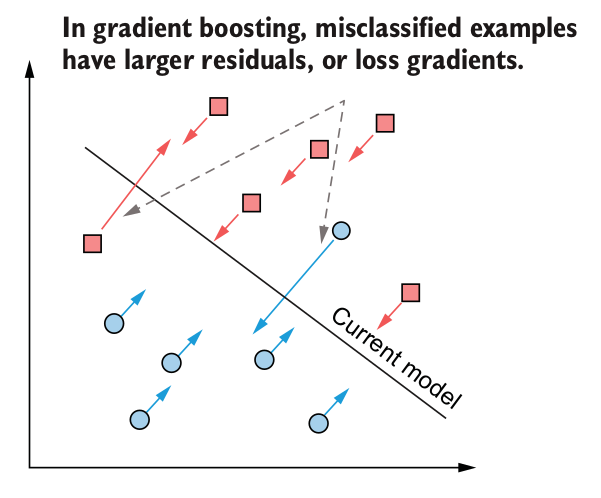


<center>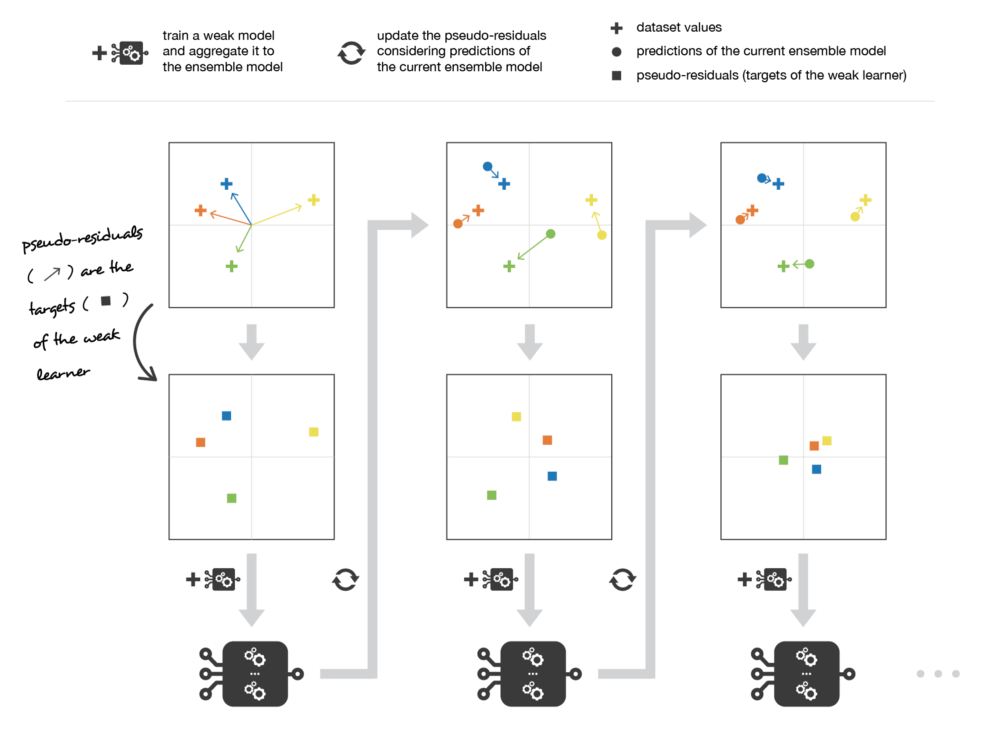</center>

### GBDT分类实验1

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gbdt_model = GradientBoostingClassifier(n_estimators=20, random_state=0)
gbdt_model.fit(X_train, y_train)

pred_train = gbdt_model.predict(X_train)
pred_test  = gbdt_model.predict(X_test)

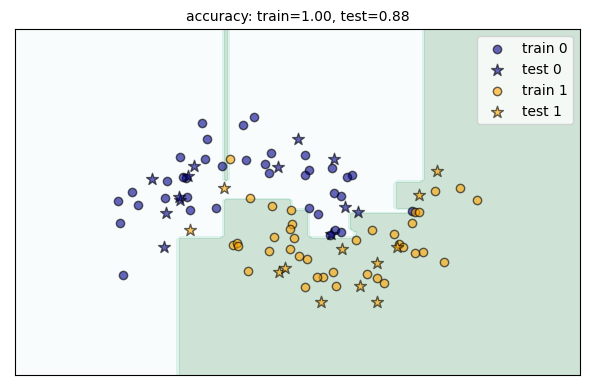

In [27]:
plt.figure(figsize=(6,4), dpi=100)
ax = plt.gca()
plot_tree_partition(gbdt_model, X_train, y_train, alpha=0.2, cmap=plt.cm.BuGn, mesh_num=100, ax=ax)
ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label="train 0", c="darkblue", ec="k", alpha=0.6)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label="test 0", c="darkblue", marker="*", s=80, ec="k", alpha=0.6)

ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label="train 1", c="orange", ec="k", alpha=0.6)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label="test 1", c="orange", marker="*", ec="k", s=80, alpha=0.6)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title(f"accuracy: train={accuracy_score(y_train, pred_train):0.2f}" 
             f", test={accuracy_score(y_test, pred_test):0.2f}", fontsize=10);
ax.legend()
plt.tight_layout();

GradientBoostingClassifier参数说明：

GB特有的：
* n_estimators  控制弱学习器的数量
* subsample  抽样比例，取值为(0, 1]
    > GB抽样与随机森林Bagging的策略不一样，随机森林是放回抽样，而GT是不放回抽样。如果取值为1，则全部样本都使用，等于没有使用子采样。
    > 如果取值小于1，则只有一部分样本会去做 GBDT 的决策树拟合。
    > 选择小于1的比例可以减少方差，即防止过拟合，但是会增加样本拟合的偏差，因此取值不能太低，一般在 [0.5, 0.8] 之间。
* learning_rate：更新过程中用到的收缩步长，取值为(0, 1]

DT特有的：
* max_depth 设置树深度，深度越大可能过拟合
* max_leaf_nodes：最大叶子节点数
* max_features 划分时考虑的最大特征数，如果特征数非常多，我们可以灵活使用其他取值来控制划分时考虑的最大特征数，以控制决策树的生成时间。
* min_samples_split：内部节点再划分所需最小样本数，这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。
* min_samples_leaf：叶子节点最少样本数，这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。
* min_weight_fraction_leaf：叶子节点最小的样本权重和，这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。
* min_impurity_split：节点划分最小不纯度，使用 min_impurity_decrease 替代。
* min_impurity_decrease：如果节点的纯度下降大于了这个阈值，则进行分裂。



In [24]:
def plot_gbdt_staged_prediction(gbrt, X, y, ax=None):
    if ax is None:
        ax = plt.gca()
        
    decisons = np.vstack([(f.ravel() == y) for f in gbrt.staged_predict(X)])
    n_samples = len(decisons)
    
    ax.imshow(decisons, aspect="auto")
    
    ax.set_yticks(range(0, n_samples, 5 if n_samples > 15 else 1));
    ax.set_xticks([]);

    ax.set_xticks(np.arange(-.5, y.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(decisons), 1), minor=True);
    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5);

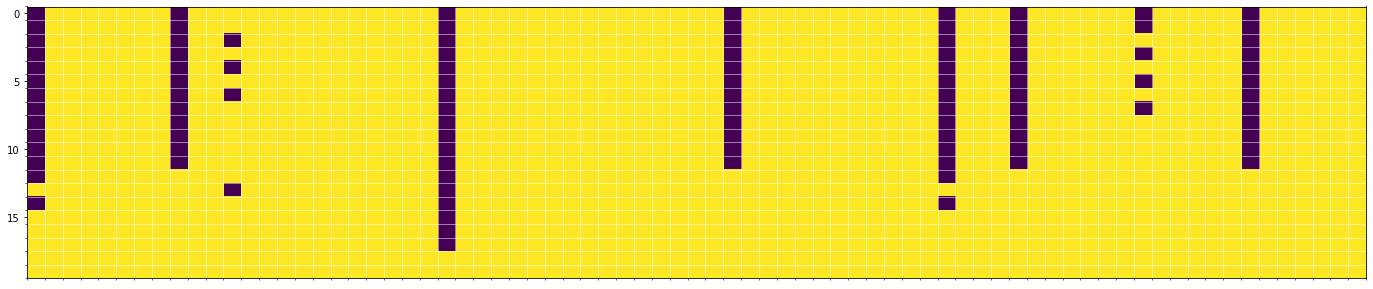

In [28]:
plt.figure(figsize=(24, 5))
plot_gbdt_staged_prediction(gbdt_model, X_train, y_train)

GBDT测试数据集每个分类结果（20次迭代）

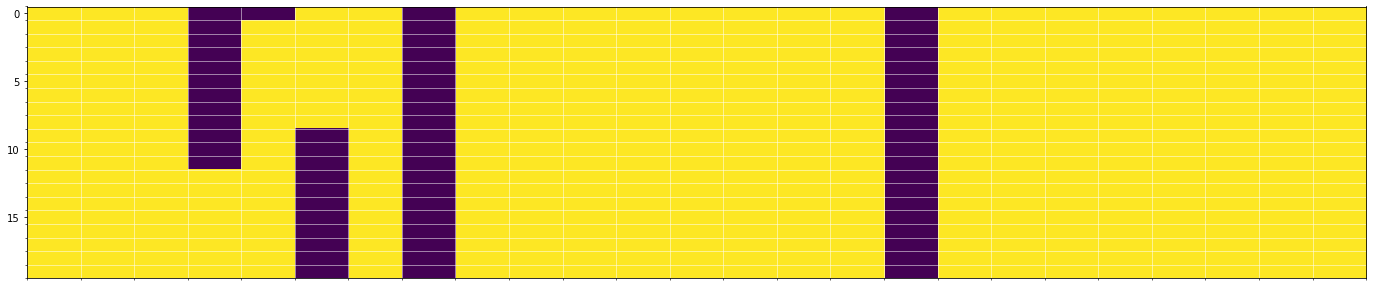

In [15]:
plt.figure(figsize=(24, 5))
plot_gbdt_staged_prediction(gbdt_model, X_test, y_test)

### GBDT实验2： 恶性肿瘤识别

In [16]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, 
                                                    random_state=42)


from sklearn.ensemble import GradientBoostingClassifier
gbdt_model = GradientBoostingClassifier(n_estimators=50, random_state=0)
gbdt_model.fit(X_train, y_train)

pred_train = gbdt_model.predict(X_train)
pred_test = gbdt_model.predict(X_test)

print(f"Accuracy on training set: { accuracy_score(y_train, pred_train) :.3f}")
print(f"Accuracy on test set: { accuracy_score(y_test, pred_test) :.3f}")

Accuracy on training set: 1.000
Accuracy on test set: 0.944


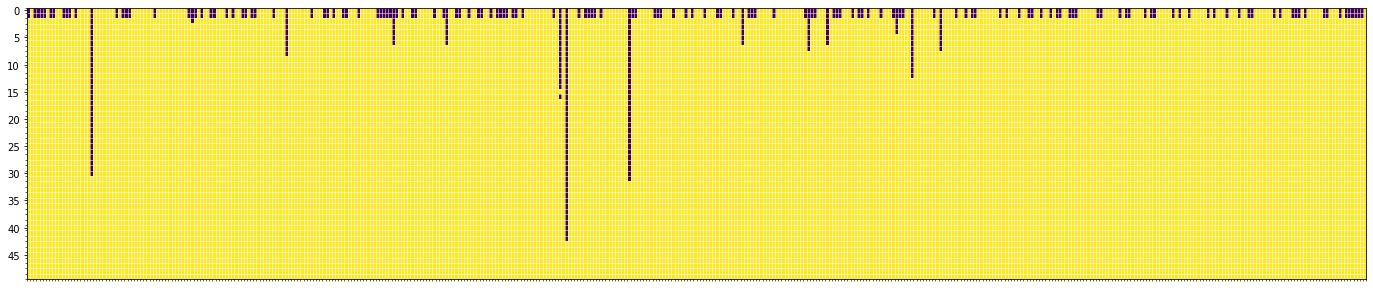

In [17]:
plt.figure(figsize=(24, 5))
plot_gbdt_staged_prediction(gbdt_model, X_train, y_train)

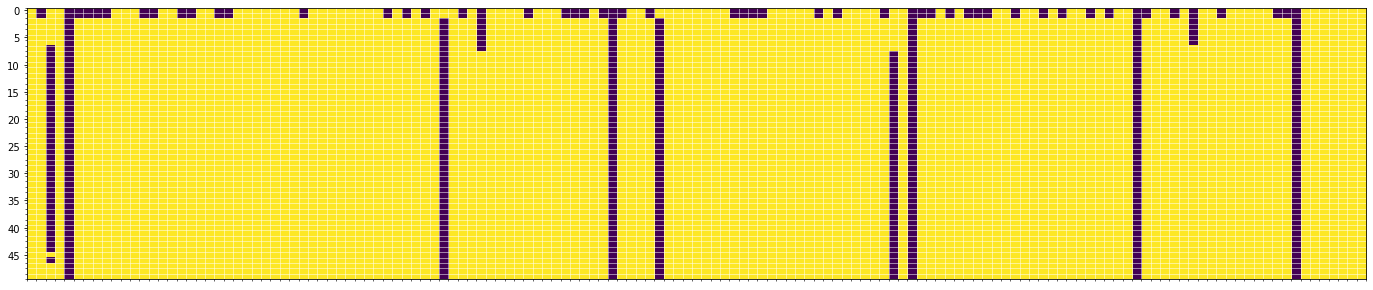

In [18]:
plt.figure(figsize=(24, 5))
plot_gbdt_staged_prediction(gbdt_model, X_test, y_test)

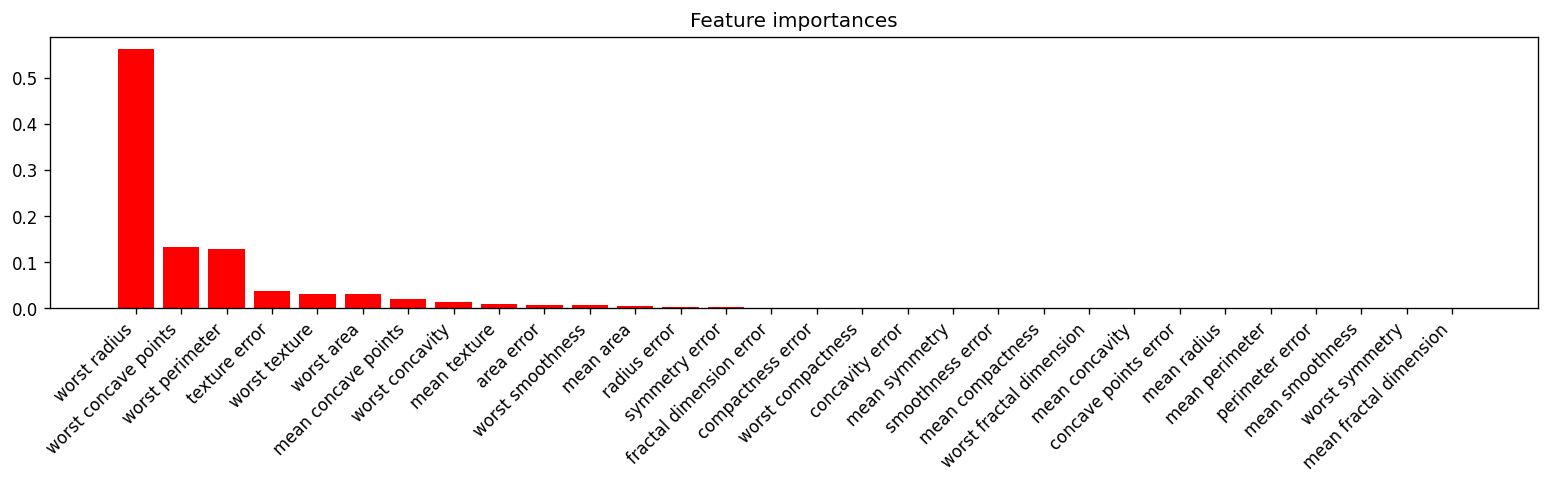

In [19]:
importances = gbdt_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(16, 3), dpi=120)
ax = plt.gca()
ax.set_title("Feature importances")
ax.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
ax.set_xticks(range(X_train.shape[1]));
ax.set_xticklabels(cancer.feature_names[indices], rotation=45, horizontalalignment='right', fontsize=10);

In [20]:
max_depths = [1, 2, 3, 4, 5, 6, 10, 15]

accuracies = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(n_estimators=100, max_depth=max_depth, random_state=0)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    accuracies.append([accuracy_score(y_train, pred_train), 
                       accuracy_score(y_test, pred_test)])

accuracies

[[0.9882629107981221, 0.958041958041958],
 [1.0, 0.951048951048951],
 [1.0, 0.958041958041958],
 [1.0, 0.951048951048951],
 [1.0, 0.951048951048951],
 [1.0, 0.9370629370629371],
 [1.0, 0.9440559440559441],
 [1.0, 0.9440559440559441]]

In [21]:
learning_rates = [0.9, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]

accuracies = []
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, random_state=0)
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    accuracies.append([accuracy_score(y_train, pred_train), 
                       accuracy_score(y_test, pred_test)])
accuracies

[[1.0, 0.958041958041958],
 [1.0, 0.958041958041958],
 [1.0, 0.958041958041958],
 [1.0, 0.9440559440559441],
 [0.9882629107981221, 0.9370629370629371],
 [0.9694835680751174, 0.9370629370629371],
 [0.6267605633802817, 0.6293706293706294],
 [0.6267605633802817, 0.6293706293706294]]

`learning_rate`学习率

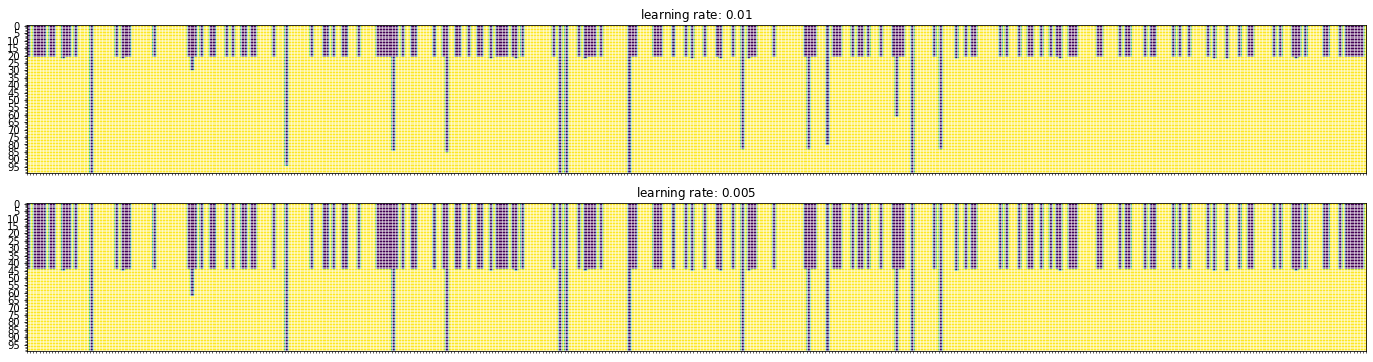

In [22]:
model1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, random_state=0)
model1.fit(X_train, y_train)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.005, random_state=0)
model2.fit(X_train, y_train)

fig, axes = plt.subplots(2, 1, figsize=(24, 6), sharex=True)
axes[0].set_title("learning rate: $0.01$")
axes[1].set_title("learning rate: $0.005$")
plot_gbdt_staged_prediction(model1, X_train, y_train, ax=axes[0])
plot_gbdt_staged_prediction(model2, X_train, y_train, ax=axes[1])


### RandomForest与GBDT的区别

相同点：
1. 都是由多棵树组成
2. 最终的结果都是由多棵树一起决定

不同点
1. 组成随机森林的树可以分类树也可以是回归树，而GBDT只由回归树组成
1. 组成随机森林的树可以并行生成，而GBDT是串行生成
1. 随机森林的结果是多数表决表决的，而GBDT则是多棵树累加之和
1. 随机森林对异常值不敏感，而GBDT对异常值比较敏感
1. 随机森林是通过减少模型的方差来提高性能，而GBDT是减少模型的偏差来提高性能的


## Stacking（堆叠）

### 原理
Stacking方法是指训练一个模型用于组合其他各个模型。首先我们先训练多个不同的模型，然后把之前训练的各个模型的输出为输入来训练一个模型，以得到一个最终的输出。理论上，Stacking可以表示上面提到的两种Ensemble方法，只要我们采用合适的模型组合策略即可。但在实际中，我们通常使用logistic回归作为组合策略。

<center>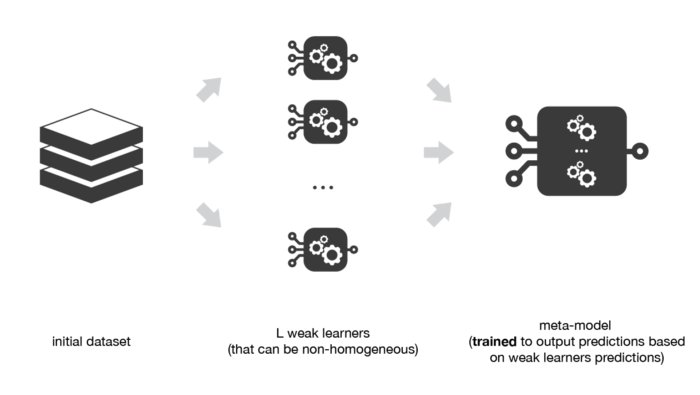</center>

也可以多层堆叠
<center>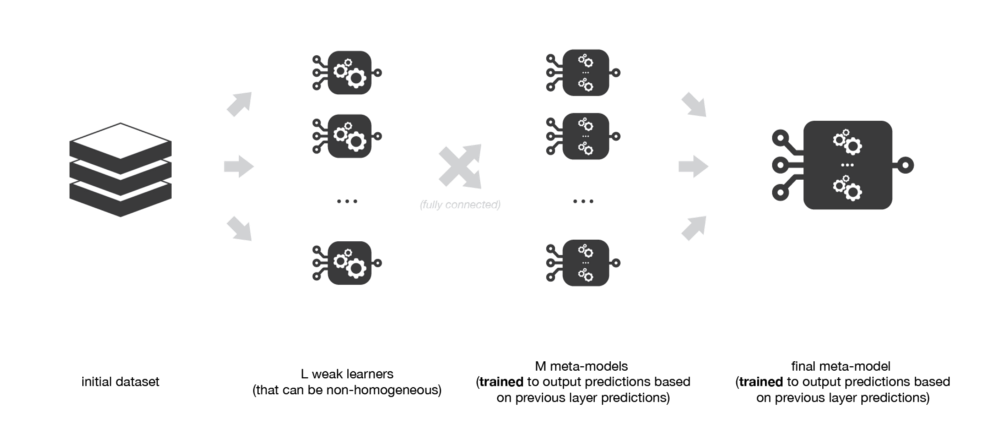</center>


### 小实验

In [40]:
def scatter_train_test_2d(X_train, X_test, y_train, y_test, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label="train 0", 
               c="darkblue", ec="k", alpha=0.6)
    ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label="test 0", 
               c="darkblue", marker="*", s=80, ec="k", alpha=0.6)

    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label="train 1", 
               c="orange", ec="k", alpha=0.6)
    ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label="test 1", 
               c="orange", marker="*", ec="k", s=80, alpha=0.6)

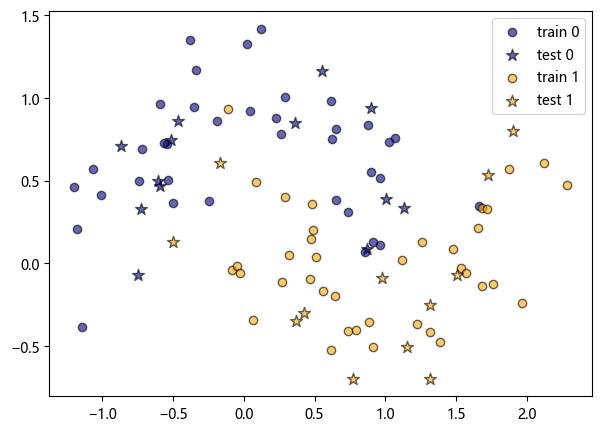

In [43]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

plt.figure(figsize=(7,5), dpi=100)
scatter_train_test_2d(X_train, X_test, y_train, y_test, ax=plt.gca())
plt.legend();

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import StackingClassifier

estimators = [('knn', KNeighborsClassifier(n_neighbors=3)), 
              ('svc', SVC(kernel="rbf")),
              ("dt", DecisionTreeClassifier(max_depth=4)),
              ("mlp", MLPClassifier(hidden_layer_sizes=[10, 2], 
                                    activation="logistic", 
                                    max_iter=1000, 
                                    solver="lbfgs", 
                                    random_state=0))]


model = StackingClassifier(estimators=estimators, 
                           final_estimator=LogisticRegression())

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

print(f"Accuracy on training set: { accuracy_score(y_train, pred_train) :.3f}")
print(f"Accuracy on test set: { accuracy_score(y_test, pred_test) :.3f}")

Accuracy on training set: 0.973
Accuracy on test set: 0.920


综合$4$个弱学习器成为一个新的学习器

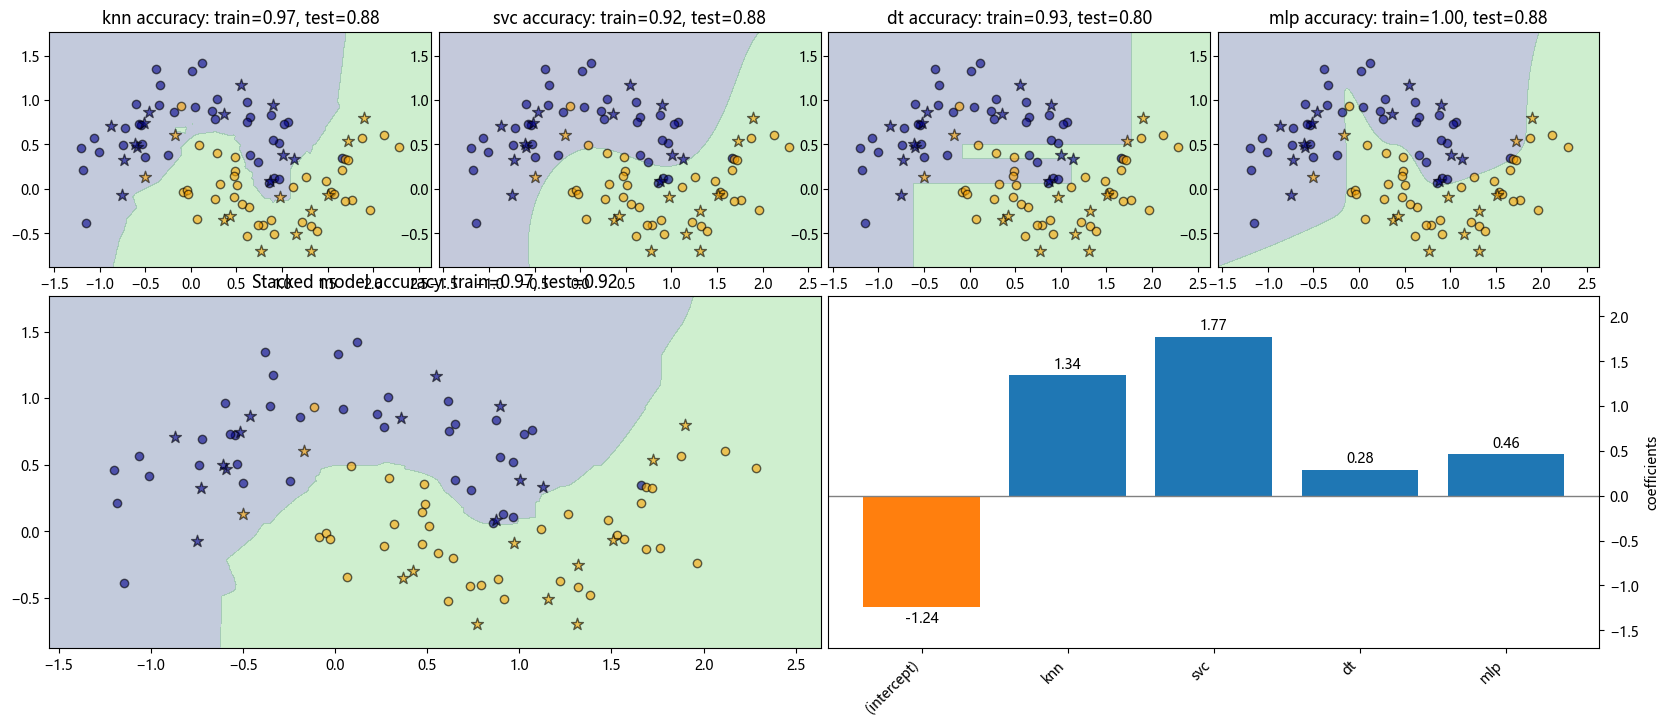

In [44]:
from plot_helper import plot_2d_separator
from plot_helper import plot_logistic_coefficients
weakmodel_names = list(model.named_estimators_.keys())

fig = plt.figure(figsize=(20, 8))
gs  = fig.add_gridspec(2, 4, hspace=0.1, wspace=0.02, height_ratios=[1, 1.5])

for i in range(4):
    ax = fig.add_subplot(gs[0, i])
    weak_model = model.estimators_[i]
    plot_2d_separator(weak_model, X_train,  ax=ax, fill=True, alpha=0.3)
    scatter_train_test_2d(X_train, X_test, y_train, y_test, ax=ax)
    pred_train = weak_model.predict(X_train)
    pred_test  = weak_model.predict(X_test)    
    ax.set_title(f"{weakmodel_names[i]} "
                 f"accuracy: train={accuracy_score(y_train, pred_train):0.2f}" 
                 f", test={accuracy_score(y_test, pred_test):0.2f}");
    
ax = fig.add_subplot(gs[1, :2])

plot_2d_separator(model, X_train,  ax=ax, fill=True, alpha=0.3)
scatter_train_test_2d(X_train, X_test, y_train, y_test, ax=ax)

pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)    
ax.set_title(f"Stacked model "
             f"accuracy: train={accuracy_score(y_train, pred_train):0.2f}" 
             f", test={accuracy_score(y_test, pred_test):0.2f}");

ax = fig.add_subplot(gs[1, 2:])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plot_logistic_coefficients(model.final_estimator_, labels=list(model.named_estimators_.keys()), ax=ax)

In [43]:
model.final_estimator_.coef_

array([[1.3763728 , 1.79524226, 0.31606758, 0.31906443]])

In [44]:
model.final_estimator_.predict(model.transform(X_test))

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1])

In [45]:
model.predict(X_test)

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1])